In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# **1. Import Data**

## 1.1. Load Data

In [2]:
# fungsi baca data
def read_data(path):
    # 1. Baca data
    data = pd.read_csv(path,
                       index_col = 0,
                       low_memory = False)
    
    # 2. Data shape awal
    print('Data shape awal:', data.shape)
    
    # 3. Drop duplicate
    data = data.drop_duplicates()

    # 4. Data shape akhir
    print('Data shape distinct:', data.shape)

    return data

In [3]:
data = read_data(path = 'bank_transactions.csv')

Data shape awal: (1048567, 8)
Data shape distinct: (1048567, 8)


In [4]:
data.reset_index(inplace = True)
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [5]:
# rename kolom untuk memudahkan
data.rename(columns={'TransactionAmount (INR)': 'TransactionAmount'}, inplace=True)
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


## 1.2. Check Data Type

In [6]:
data.dtypes

TransactionID          object
CustomerID             object
CustomerDOB            object
CustGender             object
CustLocation           object
CustAccountBalance    float64
TransactionDate        object
TransactionTime         int64
TransactionAmount     float64
dtype: object

In [7]:
# ubah data type tanggal
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data.dtypes

TransactionID                 object
CustomerID                    object
CustomerDOB                   object
CustGender                    object
CustLocation                  object
CustAccountBalance           float64
TransactionDate       datetime64[ns]
TransactionTime                int64
TransactionAmount            float64
dtype: object

# 2. Exploratory Data Analysis

In [8]:
# copy data
eda_data = data.copy()

# validasi data shape sama
print('Data shape sumber:', data.shape)
print('Data shape EDA   :', eda_data.shape)

Data shape sumber: (1048567, 9)
Data shape EDA   : (1048567, 9)


## 2.1. Data Descriptions

In [9]:
eda_data.describe()

,CustAccountBalance,TransactionTime,TransactionAmount
count,1.046198e+06,1.048567e+06,1.048567e+06
mean,1.154035e+05,1.570875e+05,1.574335e+03
std,8.464854e+05,5.126185e+04,6.574743e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.721760e+03,1.240300e+05,1.610000e+02
50%,1.679218e+04,1.642260e+05,4.590300e+02
75%,5.765736e+04,2.000100e+05,1.200000e+03
max,1.150355e+08,2.359590e+05,1.560035e+06


## 2.2. Checking Missing Values

In [10]:
eda_data.isna().sum()

TransactionID            0
CustomerID               0
CustomerDOB           3397
CustGender            1100
CustLocation           151
CustAccountBalance    2369
TransactionDate          0
TransactionTime          0
TransactionAmount        0
dtype: int64

Kolom yang memiliki missing values tidak digunakan dalam segmentasi sehingga bisa diabaikan.

## 2.3. Checking CustomerID

In [11]:
# jumlah distinct customerID
len(set(eda_data['CustomerID']))

884265

## 2.4. Checking TransactionDate 

In [12]:
# rentang tanggal transaksi
print(f'First Transaction : {str(eda_data["TransactionDate"].min())}')
print(f'Last Transaction  : {str(eda_data["TransactionDate"].max())}')

First Transaction : 2016-01-08 00:00:00
Last Transaction  : 2016-12-09 00:00:00


Dataset berisi data transaksi selama 1 tahun di 2016.

## 2.5. Creating RFM Features

In [13]:
# set "current" date (reference date)
current_date = pd.to_datetime('2021-12-31')
current_date

Timestamp('2021-12-31 00:00:00')

In [14]:
# define functions
def calculate_recency(dt):
    return (current_date - dt.max()).days

def calculate_tenure(dt):
    return (dt.max() - dt.min()).days

def calculate_frequency(dt):
    return len(set(dt))

def generate_rfmts(data):
    # 1. RFM groupby by CustomerID
    agg_dict = {
        'TransactionDate': [calculate_recency, calculate_tenure],
        'TransactionID': calculate_frequency,
        'TransactionAmount': 'sum'
    }
    data_rfmts = data.groupby('CustomerID').agg(agg_dict)

    # 2. Rename columns
    data_rfmts.columns = ['Recency', 'Tenure', 'Frequency', 'Monetary']

    return data_rfmts

In [15]:
eda_rfm_data = generate_rfmts(data = eda_data)

print('RFM data shape:', eda_rfm_data.shape)
print('Distinct cust:', len(set(eda_data['CustomerID'])))
assert eda_rfm_data.shape[0] == len(set(eda_data['CustomerID']))

RFM data shape: (884265, 4)
Distinct cust: 884265


In [16]:
eda_rfm_data.head()

,Recency,Tenure,Frequency,Monetary
CustomerID,,,,
C1010011,1922,18,2,5106.0
C1010012,1965,0,1,1499.0
C1010014,2002,182,2,1455.0
C1010018,1933,0,1,30.0
C1010024,1961,0,1,5000.0


## 2.6. Data Description

In [17]:
eda_rfm_data.describe()

,Recency,Tenure,Frequency,Monetary
count,884265.000000,884265.000000,884265.000000,8.842650e+05
mean,1976.747135,15.132699,1.185806,1.866856e+03
std,80.030366,47.066357,0.450683,7.207210e+03
min,1848.000000,0.000000,1.000000,0.000000e+00
25%,1934.000000,0.000000,1.000000,2.000000e+02
50%,1957.000000,0.000000,1.000000,5.368000e+02
75%,2001.000000,0.000000,1.000000,1.500000e+03
max,2184.000000,336.000000,6.000000,1.560035e+06


## 2.7 Data Distribution

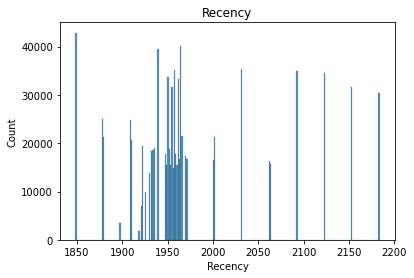

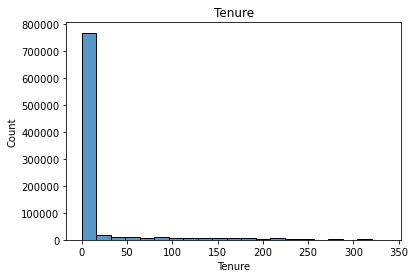

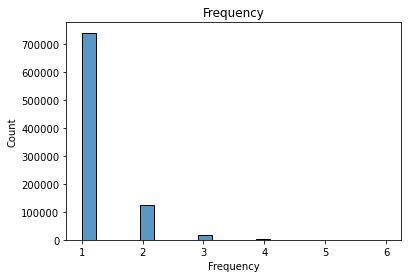

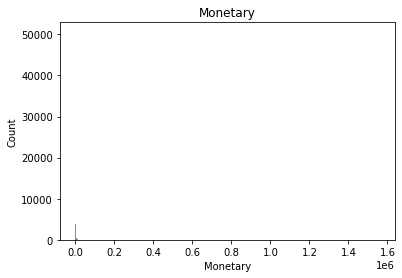

In [18]:
for col in eda_rfm_data.columns:
    x = eda_rfm_data[col]
    sns.histplot(x)
    plt.title(col)
    plt.show();

Perlu dilakukan pembersihan outlier.

In [19]:
def drop_outlier(data, cols):
    data_clean = data.copy()
    
    for col in cols:
        q1, q3 = np.quantile(data_clean[col], q=[0.25, 0.75])
        iqr = q3 - q1
        ub = q3 + 1.5*iqr
        lb = q1 - 1.5*iqr

        # Filter data
        cond_data_1 = data_clean[col] <= ub
        cond_data_2 = data_clean[col] >= lb
        data_clean = data_clean[cond_data_1 & cond_data_2]

    return data_clean

In [20]:
# Buang outlier
eda_rfm_data = drop_outlier(data = eda_rfm_data,
                            cols = ['Monetary', 'Recency'])

# Validasi
print('EDA data shape :', eda_rfm_data.shape)
eda_rfm_data.describe()

EDA data shape : (703696, 4)


,Recency,Tenure,Frequency,Monetary
count,703696.000000,703696.000000,703696.000000,703696.000000
mean,1955.742745,14.640460,1.176073,757.507639
std,53.903890,46.319111,0.430424,787.371049
min,1848.000000,0.000000,1.000000,0.000000
25%,1933.000000,0.000000,1.000000,180.000000
50%,1954.000000,0.000000,1.000000,477.520000
75%,1966.000000,0.000000,1.000000,1074.000000
max,2093.000000,336.000000,6.000000,3450.000000


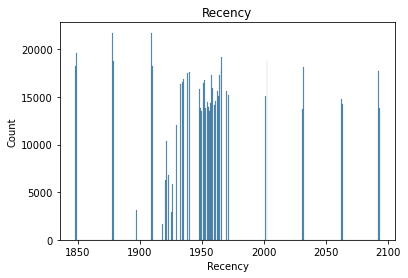

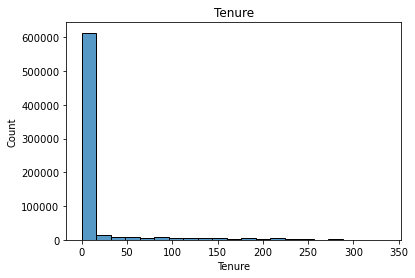

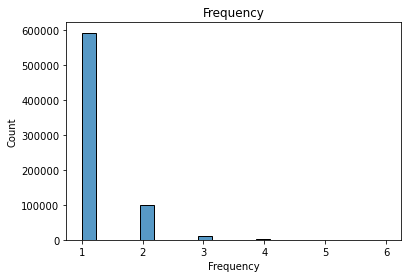

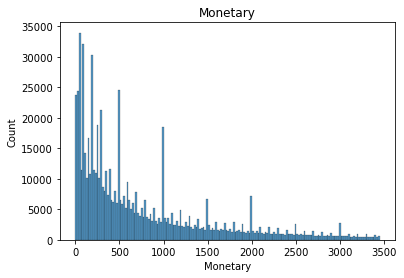

In [21]:
for col in eda_rfm_data.columns:
    x = eda_rfm_data[col]
    sns.histplot(x)
    plt.title(col)
    plt.show();

# 3. Data Preprocessing

## 3.1. Preprocess Raw Data

In [30]:
def preprocess_raw(data):
    # Buat data RFM
    data_rfm = generate_rfmts(data = data)

    # Validasi
    print('Data shape RFM:', data_rfm.shape)
    assert data_rfm.shape[0] == len(set(data['CustomerID']))

    return data_rfm

In [32]:
data_rfm = preprocess_raw(data = eda_data)
data_rfm.head()

Data shape raw: (1048567, 9)
Data shape RFM: (884265, 4)


,Recency,Tenure,Frequency,Monetary
CustomerID,,,,
C1010011,1922,18,2,5106.0
C1010012,1965,0,1,1499.0
C1010014,2002,182,2,1455.0
C1010018,1933,0,1,30.0
C1010024,1961,0,1,5000.0


## **3.2. Preprocess RFM data**

In [35]:
def preprocess_rfm(data_rfm):
    # 1. Buang outlier
    data_clean = drop_outlier(data = data_rfm,
                              cols = ['Monetary', 'Recency'])

    # 2. Filter data
    data_clean = data_clean[['Recency', 'Frequency', 'Monetary']]
    
    # 3. Tambahkan ranking frequency untuk memudahkan rank method
    data_clean['Freq_Rank'] = data_clean['Frequency'].argsort().argsort() + 1

    # 4. Validasi
    print('Data shape clean:', data_clean.shape)

    return data_clean

In [37]:
data_rfm_clean = preprocess_rfm(data_rfm = data_rfm)
data_rfm_clean.describe()

Data shape clean: (703696, 4)


,Recency,Frequency,Monetary,Freq_Rank
count,703696.000000,703696.000000,703696.000000,703696.000000
mean,1955.742745,1.176073,757.507639,351848.500000
std,53.903890,0.430424,787.371049,203139.681852
min,1848.000000,1.000000,0.000000,1.000000
25%,1933.000000,1.000000,180.000000,175924.750000
50%,1954.000000,1.000000,477.520000,351848.500000
75%,1966.000000,1.000000,1074.000000,527772.250000
max,2093.000000,6.000000,3450.000000,703696.000000


## **3.3. Normalize Data**

In [38]:
# Fit & transform scaler
from sklearn.preprocessing import MinMaxScaler

def fit_scaler(data):
    # Create & fit scaler
    scaler = MinMaxScaler()
    scaler.fit(data)

    return scaler

def transform_scaler(data, scaler):
    # Transform scaler
    data_clean = pd.DataFrame(scaler.transform(data))
    data_clean.index = data.index
    data_clean.columns = data.columns

    # Validate
    print("Data shape :", data.shape)

    return data_clean


In [39]:
scaler = fit_scaler(data = data_rfm_clean)
data_rfm_scaled = transform_scaler(data = data_rfm_clean,
                                   scaler = scaler)

data_rfm_scaled.head()

Data shape : (703696, 4)


,Recency,Frequency,Monetary,Freq_Rank
CustomerID,,,,
C1010012,0.477551,0.0,0.434493,0.000000
C1010014,0.628571,0.2,0.421739,0.842810
C1010018,0.346939,0.0,0.008696,0.724200
C1010028,0.416327,0.0,0.161449,0.724204
C1010031,1.000000,0.2,0.540290,0.842835


In [40]:
data_rfm_scaled.describe()

,Recency,Frequency,Monetary,Freq_Rank
count,703696.000000,703696.000000,703696.000000,703696.000000
mean,0.439766,0.035215,0.219567,0.500000
std,0.220016,0.086085,0.228223,0.288676
min,0.000000,0.000000,0.000000,0.000000
25%,0.346939,0.000000,0.052174,0.250000
50%,0.432653,0.000000,0.138412,0.500000
75%,0.481633,0.000000,0.311304,0.750000
max,1.000000,1.000000,1.000000,1.000000


## **3.4. Create preprocessing pipeline**

In [41]:
def preprocess_data(data, scaler=None):
    # 1. Get the RFM data
    data_rfm = preprocess_raw(data = data)

    # 2. Get the clean RFM data
    data_rfm_clean = preprocess_rfm(data_rfm = data_rfm)

    # 3. Normalize data
    if scaler is None:
        # Create a scaler
        scaler = fit_scaler(data = data_rfm_clean)

    data_clean = transform_scaler(data = data_rfm_clean,
                                  scaler = scaler)

    # 4. Validate
    print('Data shape clean :', data_clean.shape)

    return data_clean, scaler


In [43]:
data_clean, scaler = preprocess_data(data = data)

Data shape raw: (1048567, 9)
Data shape RFM: (884265, 4)
Data shape clean: (703696, 4)
Data shape : (703696, 4)
Data shape clean : (703696, 4)


In [44]:
data_clean.head()

,Recency,Frequency,Monetary,Freq_Rank
CustomerID,,,,
C1010012,0.477551,0.0,0.434493,0.000000
C1010014,0.628571,0.2,0.421739,0.842810
C1010018,0.346939,0.0,0.008696,0.724200
C1010028,0.416327,0.0,0.161449,0.724204
C1010031,1.000000,0.2,0.540290,0.842835


In [45]:
data_clean.describe()

,Recency,Frequency,Monetary,Freq_Rank
count,703696.000000,703696.000000,703696.000000,703696.000000
mean,0.439766,0.035215,0.219567,0.500000
std,0.220016,0.086085,0.228223,0.288676
min,0.000000,0.000000,0.000000,0.000000
25%,0.346939,0.000000,0.052174,0.250000
50%,0.432653,0.000000,0.138412,0.500000
75%,0.481633,0.000000,0.311304,0.750000
max,1.000000,1.000000,1.000000,1.000000


# **4. Clustering**

## 4.1. Ranking Method

In [46]:
data_bin = data_clean.copy()

In [47]:
def binning_rfm(df):
    # Calculate quantiles for each variable
    quantiles = df.quantile(q=[0.2, 0.4, 0.6, 0.8])

    # Create bins for each variable
    r_bins = [-np.inf] + list(quantiles['Recency']) + [np.inf]
    f_bins = [-np.inf] + list(quantiles['Freq_Rank']) + [np.inf]
    m_bins = [-np.inf] + list(quantiles['Monetary']) + [np.inf]

    # Create labels for the bins
    labels = [1, 2, 3, 4, 5]

    # label for recency (lower recency, higher ranking)
    labels_r = [5, 4, 3, 2, 1]
    
    # Bin each variable into five groups
    df['R_Group'] = pd.cut(df['Recency'], bins=r_bins, labels=labels_r).astype(int)
    df['F_Group'] = pd.cut(df['Freq_Rank'], bins=f_bins, labels=labels).astype(int)
    df['M_Group'] = pd.cut(df['Monetary'], bins=m_bins, labels=labels).astype(int)

    # RFM score with average
    df['RFM_Score'] = np.round((df['R_Group']+df['F_Group']+df['M_Group'])/3,2)

    return df

In [49]:
# bin the data
data_bin = binning_rfm(data_bin)
data_bin.head()

,Recency,Frequency,Monetary,Freq_Rank,R_Group,F_Group,M_Group,RFM_Score
CustomerID,,,,,,,,
C1010012,0.477551,0.0,0.434493,0.000000,2,1,5,2.67
C1010014,0.628571,0.2,0.421739,0.842810,1,5,5,3.67
C1010018,0.346939,0.0,0.008696,0.724200,4,4,1,3.00
C1010028,0.416327,0.0,0.161449,0.724204,3,4,3,3.33
C1010031,1.000000,0.2,0.540290,0.842835,1,5,5,3.67


In [50]:
data_bin.dtypes

Recency      float64
Frequency    float64
Monetary     float64
Freq_Rank    float64
R_Group        int32
F_Group        int32
M_Group        int32
RFM_Score    float64
dtype: object

In [51]:
data_bin.describe()

,Recency,Frequency,Monetary,Freq_Rank,R_Group,F_Group,M_Group,RFM_Score
count,703696.000000,703696.000000,703696.000000,703696.000000,703696.00000,703696.000000,703696.000000,703696.000000
mean,0.439766,0.035215,0.219567,0.500000,3.04329,2.999997,2.999274,3.014194
std,0.220016,0.086085,0.228223,0.288676,1.39615,1.414216,1.414315,0.893338
min,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000
25%,0.346939,0.000000,0.052174,0.250000,2.00000,2.000000,2.000000,2.330000
50%,0.432653,0.000000,0.138412,0.500000,3.00000,3.000000,3.000000,3.000000
75%,0.481633,0.000000,0.311304,0.750000,4.00000,4.000000,4.000000,3.670000
max,1.000000,1.000000,1.000000,1.000000,5.00000,5.000000,5.000000,5.000000


In [52]:
def assign_segment(rfm_df):
    # Beri nama segmen (1 terbaik)
    labels = ['5. At Risk Customers', '4. Below Average Customers',
              '3. Average Customers', '2. Good Customers',
              '1. Best Customers']

    rfm_df['Segment'] = pd.cut(rfm_df['RFM_Score'],
                               bins = [0, 1, 2, 3, 4, 5],
                               labels = labels)
    return rfm_df

In [53]:
data_bin = assign_segment(data_bin)

In [54]:
data_bin.head()

,Recency,Frequency,Monetary,Freq_Rank,R_Group,F_Group,M_Group,RFM_Score,Segment
CustomerID,,,,,,,,,
C1010012,0.477551,0.0,0.434493,0.000000,2,1,5,2.67,3. Average Customers
C1010014,0.628571,0.2,0.421739,0.842810,1,5,5,3.67,2. Good Customers
C1010018,0.346939,0.0,0.008696,0.724200,4,4,1,3.00,3. Average Customers
C1010028,0.416327,0.0,0.161449,0.724204,3,4,3,3.33,2. Good Customers
C1010031,1.000000,0.2,0.540290,0.842835,1,5,5,3.67,2. Good Customers


In [55]:
# Transform balik
for col in ['Recency', 'Frequency', 'Monetary']:
    # inverse transform X
    x = data_bin[col]

    # Find index
    idx = scaler.feature_names_in_.tolist().index(col)
    max_val = scaler.data_max_[idx]
    min_val = scaler.data_min_[idx]

    # Inverse transform
    data_bin[col] = x*(max_val-min_val) + min_val

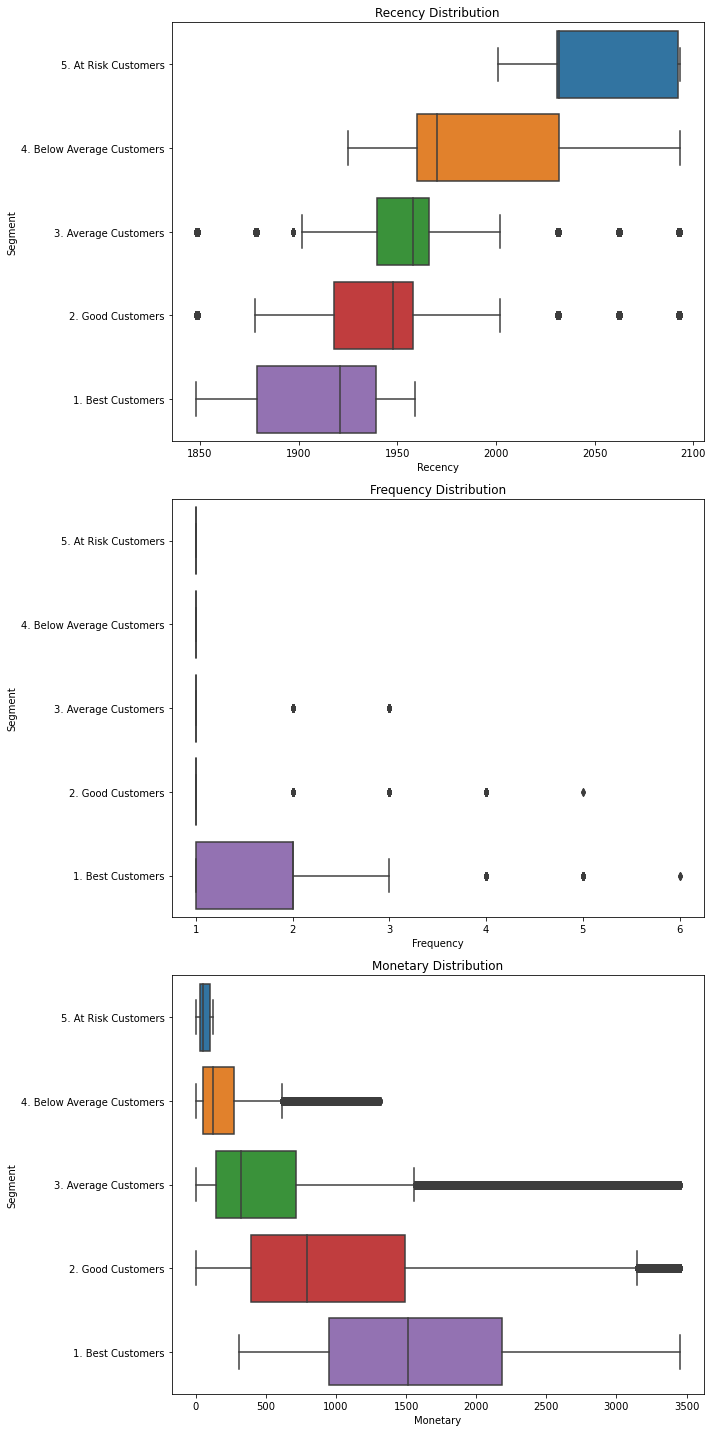

In [56]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.boxplot(data = data_bin,
                y = 'Segment',
                x = col,
                ax = axes[i])

    axes[i].set_title(f'{col} Distribution')

plt.tight_layout()
plt.show()

In [57]:
# groupby to get aggregate mean of each RFM variable
data_bin.groupby('Segment').agg({'Recency':'mean',
                                 'Frequency':'mean',
                                 'Monetary':'mean',
                                 'Segment':'count'}).round(2)

,Recency,Frequency,Monetary,Segment
Segment,,,,
5. At Risk Customers,2047.16,1.00,59.90,6046
4. Below Average Customers,1997.44,1.00,207.01,120763
3. Average Customers,1963.43,1.02,560.45,282574
2. Good Customers,1936.91,1.23,1020.92,211811
1. Best Customers,1910.01,1.84,1613.08,82502


In [58]:
data_bin['Segment'].value_counts()

3. Average Customers          282574
2. Good Customers             211811
4. Below Average Customers    120763
1. Best Customers              82502
5. At Risk Customers            6046
Name: Segment, dtype: int64

## 4.2. K-Means Clustering

In [59]:
from sklearn.cluster import KMeans

In [60]:
data_cluster_clean = data_clean[['Recency', 'Frequency', 'Monetary']]

In [73]:
# Set empty list
inertia = []

# iterate for
for k in range(1, 11):
    # create
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    # fit object
    kmeans.fit(data_cluster_clean)

    # append results
    inertia.append(kmeans.inertia_)


Text(0.5, 1.0, 'Elbow Method')

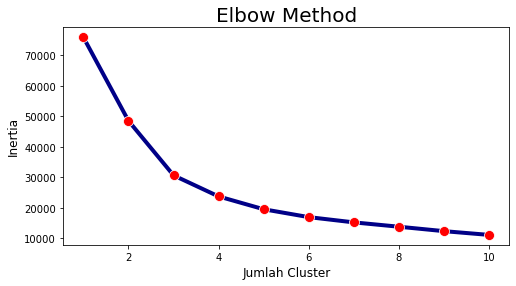

In [62]:
plt.figure(figsize=(8, 4))

# plt.plot(inertia)
sns.lineplot(x=range(1, 11), y=inertia, color='#000087',
             linewidth = 4, marker='o', markersize=10,
             markerfacecolor='red')

plt.xlabel('Jumlah Cluster', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method', fontsize=20)

In [63]:
kmeans_best = KMeans(n_clusters = 3,
                     random_state = 42,
                     n_init = 10)

kmeans_best.fit(data_cluster_clean)

KMeans(n_clusters=3, n_init=50, random_state=42)

In [64]:
data_label = kmeans_best.predict(data_cluster_clean)
data_label

array([1, 1, 0, ..., 0, 0, 0])

In [65]:
centroids = kmeans_best.cluster_centers_

In [66]:
centroid_df = pd.DataFrame(centroids,
                           columns=['Recency', 'Frequency', 'Monetary']).rename_axis('Cluster', axis='index')

centroid_df

,Recency,Frequency,Monetary
Cluster,,,
0,0.360005,0.027314,0.117402
1,0.391601,0.081360,0.604368
2,0.815880,0.010373,0.156777


### **Analysis**

In [67]:
# Transform balik
data_cluster = pd.DataFrame(scaler.inverse_transform(data_clean))
data_cluster.index = data_clean.index
data_cluster.columns = data_clean.columns

data_cluster = data_cluster[['Recency', 'Frequency', 'Monetary']]
data_cluster['label'] = data_label
data_cluster.head()

,Recency,Frequency,Monetary,label
CustomerID,,,,
C1010012,1965.0,1.0,1499.0,1
C1010014,2002.0,2.0,1455.0,1
C1010018,1933.0,1.0,30.0,0
C1010028,1950.0,1.0,557.0,0
C1010031,2093.0,2.0,1864.0,2


In [68]:
# Calculate average values for each RFM_Level, and return a size of each segment
data_cluster.groupby('label').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'label':'count',
}).round(1)

,Recency,Frequency,Monetary,label
label,,,,
0,1936.2,1.1,405.0,451690
1,1944.0,1.4,2084.9,138518
2,2047.9,1.1,540.4,113488


In [80]:
# Function to assign label
def assign_label(val):
    """Function to assign label"""
    if val == 0:
        return '2. Average Customer'
    elif val == 1:
        return '1. Best Customer'
    else:
        return '3.At Risk Customer'

data_cluster['Segment'] = data_cluster['label'].apply(assign_label)

# check result
data_cluster.head()

,Recency,Frequency,Monetary,label,Segment
CustomerID,,,,,
C1010012,1965.0,1.0,1499.0,1,1. Best Customer
C1010014,2002.0,2.0,1455.0,1,1. Best Customer
C1010018,1933.0,1.0,30.0,0,2. Average Customer
C1010028,1950.0,1.0,557.0,0,2. Average Customer
C1010031,2093.0,2.0,1864.0,2,3.At Risk Customer


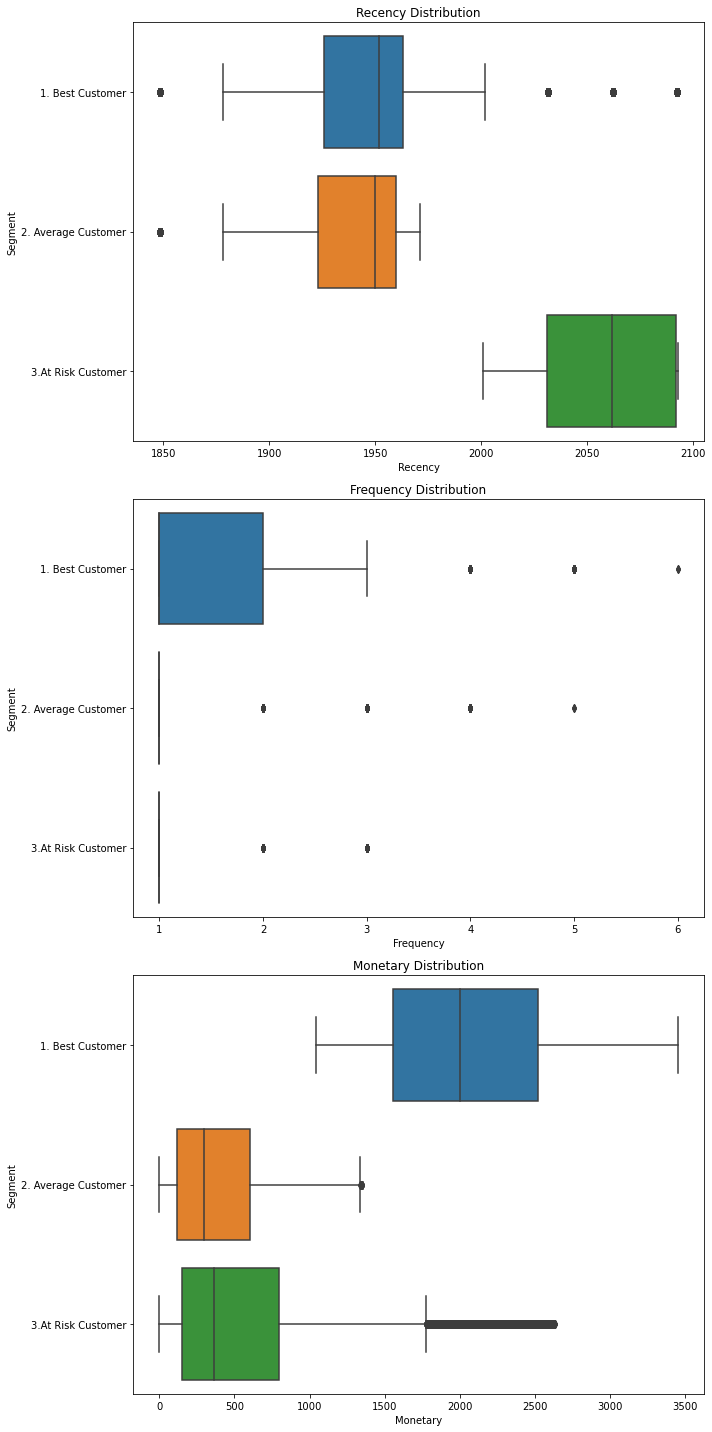

In [81]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.boxplot(data = data_cluster,
                y = 'Segment',
                x = col,
                ax = axes[i])

    axes[i].set_title(f'{col} Distribution')

plt.tight_layout()
plt.show()

In [82]:
# groupby to get aggregate mean of each RFM variable
data_cluster.groupby('Segment').agg({'Recency':'mean',
                                 'Frequency':'mean',
                                 'Monetary':'mean',
                                 'Segment':'count'}).round(2)

,Recency,Frequency,Monetary,Segment
Segment,,,,
1. Best Customer,1943.98,1.41,2084.89,138518
2. Average Customer,1936.20,1.14,404.99,451690
3.At Risk Customer,2047.89,1.05,540.40,113488
